# Semantic Entropy ([Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0)) Demo

Content
1. [Introduction](#section1')
2. [Set up LLM and Prompts](#section2')
3. [Generate Responses and Confidence Scores](#section3')<br>
4. [Performance Evaluation](#section4')

In [1]:
import warnings

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner
from uqlm.quantifiers import SemanticEntropy

warnings.filterwarnings("ignore")

/home/jupyter/.cache/pypoetry/virtualenvs/uqlm-g7jzkC-R-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-05 18:16:36.595153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741198596.659426   20799 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741198596.667788   20799 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 18:16:36.898802: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU in

<a id='section1'></a>
## 1. Introduction

Black-box Uncertainty Quantification (UQ) methods treat the LLM as a black box and evaluate response consistency to estimate response-level confidence. This demo provides an illustration of a state-of-the-art black-box UQ method known as Semantic Entropy ([Farquhar et al., 2024](https://www.nature.com/articles/s41586-024-07421-0)).

**Pros:**

*   ✅  **Universal Compatibility:** Works with any LLM.
*   ✅  **Intuitive:** Easy to understand and implement.
*   ✅  **No Internal Access Required:** Doesn't need token probabilities or model internals.

**Cons:**

*   ⚠️  **Higher Cost:** Requires multiple generations per prompt.
*   ⚠️  **Slower:**  Multiple generations and comparison calculations increase latency.

<a id='section2'></a>
## 2. Set up LLM and Prompts

In [2]:
# Load example dataset (SVAMP)
svamp = (
    load_example_dataset("svamp")
    .rename(columns={"question_concat": "question", "Answer": "answer"})[
        ["question", "answer"]
    ]
    .head(50)
)
svamp.head()

Loading dataset - svamp...
Processing dataset...
Dataset ready!


,question,answer
0,There are 87 oranges and 290 bananas in Philip...,145
1,Marco and his dad went strawberry picking. Mar...,19
2,Edward spent $ 6 to buy 2 books each book cost...,3
3,Frank was reading through his favorite book. T...,198
4,There were 78 dollars in Olivia's wallet. She ...,63


In [3]:
# Define prompts
MATH_INSTRUCTION = (
    "When you solve this math problem only return the answer with no additional text.\n"
)
prompts = [MATH_INSTRUCTION + prompt for prompt in svamp.question]

In [4]:
# Instantiate BaseChatModel
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-pro")

Note that although we use `ChatVertexAI` in this example, any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used.

<a id='section3'></a>
## 3. Generate responses and confidence scores

#### `SemanticEntropy()` - Class for detecting bad and speculative answer from a Large Language Model (LLM Hallucination).

**Class Attributes:**
- `llm` (**BaseChatModel, default=None**) A langchain llm (`BaseChatModel`). User is responsible for specifying temperature and other relevant parameters to the constructor of their `BaseChatModel` object.
- `nli_scorer` - (**class_object, default=None**) A class object to compute the semantic similarity score using a natural language inference model. This object must have a `predict` method, which returns probability of contradiction for provided input. Default case, uses DeBERTA model trained on MNLI dataset.
- `postprocessor` - (**f(str) -> str, default=None**) A user-defined function to postprocess responses.
- `device` - (**str or torch.device input or torch.device object, default="cpu"**) Specifies the device that classifiers use for prediction. Set to "cuda" for classifiers to be able to leverage the GPU.
- `system_prompt` - (**str or None, default="You are a helpful assistant."**) Optional argument for user to provide custom system prompt
- `max_calls_per_min` - (**int, default=None**) Specifies how many api calls to make per minute to avoid a rate limit error. By default, no limit is specified.
- `use_n_param` (**bool, default=False**) Specifies whether to use `n` parameter for `BaseChatModel`. Not compatible with all `BaseChatModel` classes. If used, it speeds up the generation process substantially when `num_responses` is large.

**Class Methods:**
1. `evaluate` - Generate responses and evaluate confidence scores on LLM responses for the provided prompts.

    **Method Attributes:**
    - `prompts` - (**list of str**) A list of input prompts for the model.
    - `responses` - (**list of str, default=None**) A list of model responses for the prompts. If not provided, this method will generate responses for `self.llm`. 
    - `multiple_responses` - (**list of list of str, default=None**) A list of multiple model responses, each element (multiple_responses[i]) is a list of str, containing multiple model responses for prompts[i]. If not provided, this method will generate responses for `self.llm`.
    - `mr_temperature` - (**float, default=1**) The `temperature` parameter for llm model to generate multiple responses for observed consistency.
    - `num_responses` - (**int, default=5**) The number of multiple responses used to compute observed consistency.
    - `use_best` - (**bool, default=True**) Specifies whether to swap the original response for the uncertainty-minimized response based on semantic entropy clusters. 
    
    **Returns:**
        `UQResult` containing data (prompts, responses, and confidence scores) and metadata

In [5]:
import torch

device = torch.device("cuda")  # use if GPU available
# device = None

In [6]:
se = SemanticEntropy(
    llm=llm,
    max_calls_per_min=250,  # set value to avoid rate limit error
    device=device,  # use if GPU available
    # postprocessor=math_postprocessor,
    use_n_param=False,  # Set True if using AzureChatOpenAI for faster generation
)

Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
results = await se.evaluate(
    prompts=prompts,
    num_responses=10,
    # responses=responses # provide if responses already generated
    # multiple_responses=multiple_responses # provide if candidate responses already generated
)

Generating responses...
Generating candidate responses...
Computing confidence scores...


In [8]:
result_df = results.to_df()
result_df.head(5)

,prompt,response,entropy_value,confidence_score,multiple_responses
0,When you solve this math problem only return t...,145,0.000000,1.000000,"[145, 145, 145, 145, 145, 145, 145, 145, 145, ..."
1,When you solve this math problem only return t...,19,1.067094,0.536567,"[19 pounds, 19 pounds., 19, 19 pounds. , 19 po..."
2,When you solve this math problem only return t...,$3,1.540306,0.331054,"[$3, $3, $3, $4, $3.00, $ 3, $3.00, $ 9., $3, 4$]"
3,When you solve this math problem only return t...,198,0.304636,0.867698,"[198, 198, 198, 198, 198, 198, 198\n, 198, 198..."
4,When you solve this math problem only return t...,63,1.055102,0.541775,"[63, 63, 63, 63 dollars. \nWould you like me t..."


<a id='section4'></a>
## 4. Evaluate performance

In [9]:
# Populate correct answers and grade responses
result_df["answer"] = svamp.answer
result_df["response_correct"] = [
    math_postprocessor(r) == a for r, a in zip(result_df["response"], svamp["answer"])
]
result_df.head(5)

,prompt,response,entropy_value,confidence_score,multiple_responses,answer,response_correct
0,When you solve this math problem only return t...,145,0.000000,1.000000,"[145, 145, 145, 145, 145, 145, 145, 145, 145, ...",145,True
1,When you solve this math problem only return t...,19,1.067094,0.536567,"[19 pounds, 19 pounds., 19, 19 pounds. , 19 po...",19,True
2,When you solve this math problem only return t...,$3,1.540306,0.331054,"[$3, $3, $3, $4, $3.00, $ 3, $3.00, $ 9., $3, 4$]",3,True
3,When you solve this math problem only return t...,198,0.304636,0.867698,"[198, 198, 198, 198, 198, 198, 198\n, 198, 198...",198,True
4,When you solve this math problem only return t...,63,1.055102,0.541775,"[63, 63, 63, 63 dollars. \nWould you like me t...",63,True


In [11]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.72


Next we will plot filtered LLM accuracy at various confidence score thresholds. The idea is to measure the LLM's performance when we consider responses with confidence scores above a given threshold.

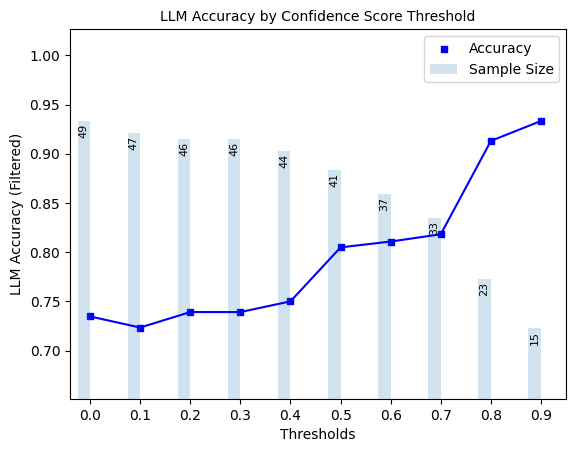

In [22]:
plot_model_accuracies(
    scores=result_df.confidence_score, correct_indicators=result_df.response_correct
)

Lastly, we will compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we can compute precision, recall, and F1-score for semantic entropy predictions of whether responses are correct.

In [26]:
# instantiate UQLM tuner object for threshold selection
t = Tuner()

# Define score vector and corresponding correct indicators (i.e. ground truth)
y_scores = result_df["confidence_score"]  # confidence score
correct_indicators = (
    result_df.response_correct
) * 1  # Whether responses is actually correct

# Solve for threshold that maximizes F1-score
best_threshold = t.tune_threshold(
    y_scores=y_scores,
    correct_indicators=correct_indicators,
    thresh_objective="fbeta_score",
)
y_pred = [
    (s > best_threshold) * 1 for s in y_scores
]  # predicts whether response is correct based on confidence score
print(f"Semantic entropy F1-optimal threshold: {best_threshold}")

Semantic entropy F1-optimal threshold: 0.5


In [25]:
# evaluate precision, recall, and f1-score of semantic entropy predictions of correctness
print(
    f"Semantic entropy precision: {precision_score(y_true=correct_indicators, y_pred=y_pred)}"
)
print(
    f"Semantic entropy recall: {recall_score(y_true=correct_indicators, y_pred=y_pred)}"
)
print(
    f"Semantic entropy f1-score: {f1_score(y_true=correct_indicators, y_pred=y_pred)}"
)

Semantic entropy precision: 0.8048780487804879
Semantic entropy recall: 0.9166666666666666
Semantic entropy f1-score: 0.8571428571428571
